# Chapter 5 支持向量机

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "svm"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. 线性SVM分类（Linear SVM Classification）

支持向量机背后的基本思想最好可以用一些视觉效果来解释。

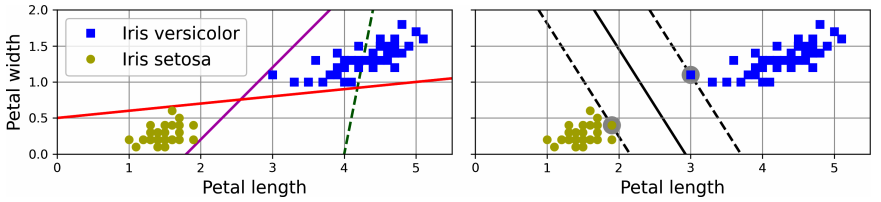

如图显示了在第4章的末尾介绍的部分鸢尾花数据集。这两个类可以很容易地用一条直线分开（它们是线性可分离的）。左图显示了三种可能的线性分类器的决策边界。用虚线表示决策边界的模型非常糟糕，甚至不能正确地分离类。另外两个模型在这个训练集上工作得很好，但是它们的决策边界非常接近实例，这些模型可能在新实例上表现得很好。相比之下，右边图中的实线代表了SVM分类器的决策边界；这条线不仅分离了两个类，而且尽可能远离最近的训练实例。您可以将SVM分类器看作是拟合类之间尽可能最宽的街道（由平行虚线表示）。这被称为 **大边际分类（large margin classification）** 。

请注意，添加更多远离街道的训练实例将完全不会影响决策边界：它完全由位于街道边缘的实例决定（或“支持”）。这些实例被称为 **支持向量（support vectors）** （它们在上图中被圈了出来）。

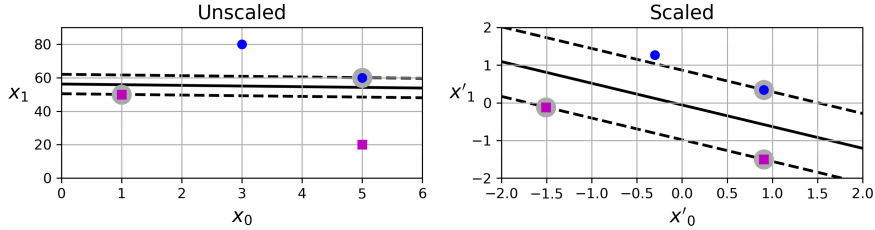

**注意**：支持向量机对特征尺度很敏感，如图所示。在左图中，垂直尺度比水平尺度大得多，所以尽可能宽的街道接近水平。在特征缩放之后（例如，使用Scikit-Learn的 **StandardScaler** ）后，在正确的图中的决策边界看起来要好得多。

### 1.1 软边际分类（Soft Margin Classification）

如果我们严格规定所有的实例必须在街道和正确的一边，这被称为 **硬边际分类（hard margin classification）** 。硬边际分类有两个主要问题。首先，它只在数据是线性可分的情况下有效。其次，它对异常值很敏感。

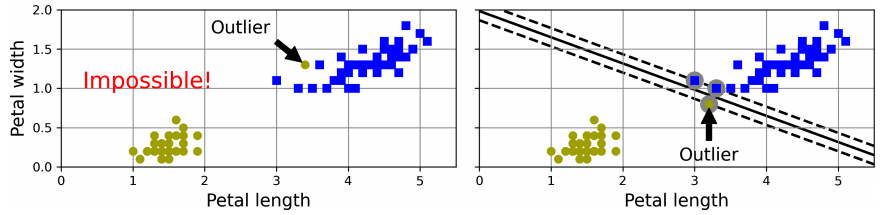

上图显示了只有一个额外的离群值的鸢尾花数据集：在左边，不可能找到一个硬边际；在右边，决策边界最终与我们之前看到的没有离群值的决策边界非常不同，而且模型可能泛化不好。

为了避免这些问题，我们需要使用一个更灵活的模型。其目标是在保持街道尽可能大和限制边际违规（即最终出现在街道中间或甚至出现在错误的一侧）之间找到一个良好的平衡。这被称为 **软边际分类（soft margin classification）** 。

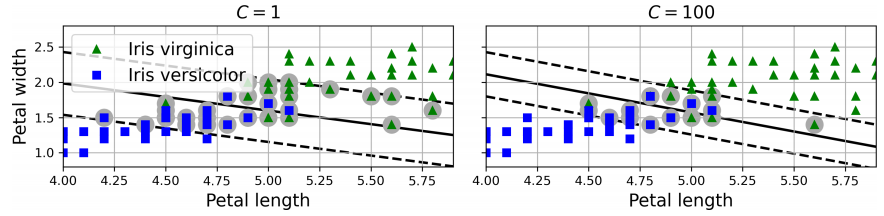

当使用Scikit-Learn创建SVM模型时，可以指定几个超参数，包括正则化超参数 **C** 。如果将其设置为低值，则将使用上图左侧的模型。如果值很高，你就可以得到右边的模型。正如你所看到的，减少 **C** 会使街道面积更大，但它也会导致更多的边际违规。换句话说，减少 **C** 会导致更多的实例支持街道，所以过拟合的风险更小。但是如果你减少得太多，那么模型最终会欠拟合，就像这里的情况一样：**C=100** 的模型看起来比 **C=1** 的模型更泛化。

**注意**：如果你的 SVM 模型是过拟合的，你可以尝试通过减少 **C** 来正则化它。

下面的Scikit-Learn代码加载鸢尾花数据集，并训练一个线性的SVM分类器来检测鸢尾花。管道首先缩放特性，然后使用 C=1 的 **LinearSVC** ：

In [5]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)  # Iris virginica

svm_clf = make_pipeline(StandardScaler(),
                        LinearSVC(C=1, random_state=42))
svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(C=1, random_state=42))])

然后，像往常一样，您可以使用该模型来进行预测：

In [6]:
X_new = [[5.5, 1.7], [5.0, 1.5]]

svm_clf.predict(X_new)

array([ True, False])

第一个植物被归类为 Iris virginica ，而第二个则不是。让我们来看看 SVM 用来做出这些预测的分数。这些度量了每个实例和决策边界之间的有符号距离：

In [7]:
svm_clf.decision_function(X_new)

array([ 0.66163411, -0.22036063])

与 **LogisticRegression** 不同，**LinearSVC** 没有 **predict_proba()** 方法来估计类的概率。也就是说，如果您使用 SVC 类（简要讨论）而不是 LinearSVC ，并且如果您将它的 **probability** 超参数设置为 True ，那么该模型将在训练结束时拟合一个额外的模型，以将 SVM 决策函数分数映射到估计的概率。在引擎下，这需要使用5折交叉验证为训练集中的每个实例生成样本外预测，然后训练 **LogisticRegression** 模型，因此它将大大降低训练速度。之后，**predict_proba()** 和 **predict_log_proba()** 方法将可以使用。

## 2. 非线性SVM分类（Nonlinear SVM Classification）

虽然线性 SVM 分类器是有效的，而且经常工作得惊人地好，但许多数据集甚至不接近于线性可分的。处理非线性数据集的一种方法是添加更多的特征，如多项式特征（正如我们在第4章中所做的）；在某些情况下，这可能导致一个线性可分离的数据集。

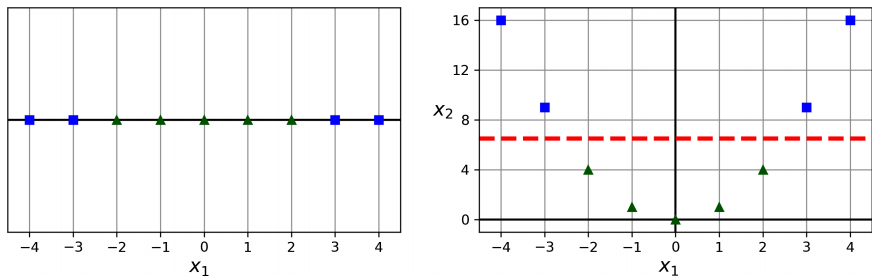

考虑上图中的左图：它代表一个简单的数据集，只有一个特征 $x_1$ 。如您所见，这个数据集不是线性可分离的。但是，如果您添加了第二个特征 $x_2=(x_1)^2$，则所得到的2D数据集是完全线性可分的。

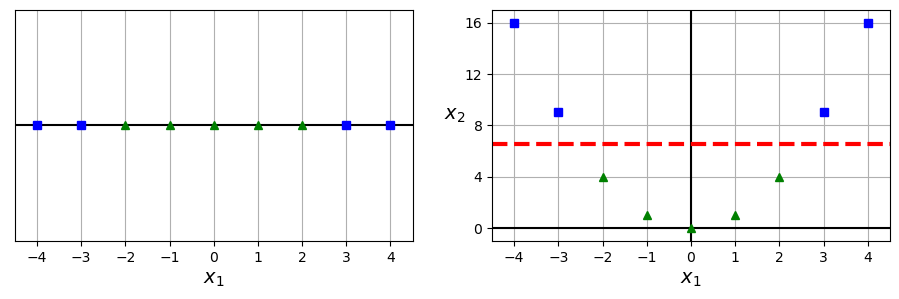

In [13]:
# extra code – this cell generates and saves Figure

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel("$x_1$")
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$  ", rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

为了使 Scikit-Learn 实现这个想法，您可以创建一个包含 **PolynomialFeatures** 转换器的管道，然后是一个 **StandardScaler** 和一个 **LinearSVC** 分类器。让我们在月亮数据集上测试一下，这是一个用于二进制分类的玩具数据集，其中数据点的形状为两个交错的新月。您可以使用 **make_moons()** 函数来生成这个数据集：

In [16]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

polynomial_svm_clf = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, random_state=42)
)

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, max_iter=10000, random_state=42))])

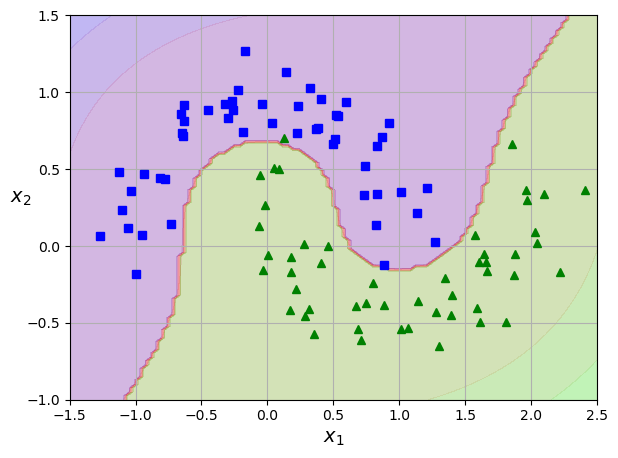

In [9]:
# extra code – this cell generates and saves Figure 5–6

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

### 2.1 多项式核（Polynomial Kernel）

添加多项式特征很容易实现，并且可以使用各种机器学习算法（不仅仅是支持向量机）。也就是说，在低阶多项式下，这种方法不能处理非常复杂的数据集，而在高阶多项式下，它产生了大量的特征，使得模型太慢。

幸运的是，当使用支持向量机时，您可以应用一种几乎奇迹般的数学技术，称为 **内核技巧（kernel trick）** 。内核技巧使您能够获得相同的结果，就像您已经添加了许多多项式特性一样，而不需要实际添加它们。这意味着特征的数量没有组合爆炸。这个技巧是由 **SVC** 类实现的。让我们在卫星数据集上测试一下：

In [10]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

这段代码使用一个3阶多项式核来训练一个SVM分类器，在下图的左边表示。右边是另一个使用10阶多项式核的SVM分类器。显然，如果你的模型是过拟合的，你可能想要减少多项式度。相反，如果它欠拟合，您可以尝试增加它。超参数 **coef0** 控制了模型受高阶项和低阶项的影响程度。

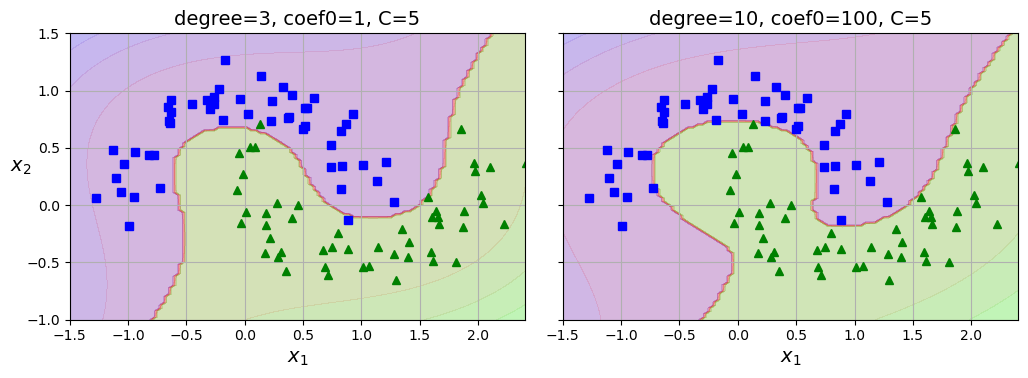

In [11]:
# extra code – this cell generates and saves Figure 5–7

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=3, coef0=1, C=5")

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("degree=10, coef0=100, C=5")
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

**注意**：虽然超参数通常会被自动调优（例如，使用随机搜索），但是了解每个超参数的实际功能以及它如何与其他超参数交互是很好的：这样，你就可以将搜索范围缩小到更小的空间。

### 2.2 相似性特征（Similarity Features）

另一种用于解决非线性问题的技术是添加使用相似性函数计算的特征，该函数度量每个实例与特定 **地标（landmark）** 的相似程度，就像我们在第二章中添加地理相似性特征时所做的那样。例如，让我们从前面的1D数据集，并在 $x_1=-2$ 和 $x_1=1$ 处添加两个地标。接下来，我们将定义相似度函数为高斯RBF，使用 $\gamma=0.3$ 。这是一个钟形函数，从0（离地标非常远）到1（在地标）。

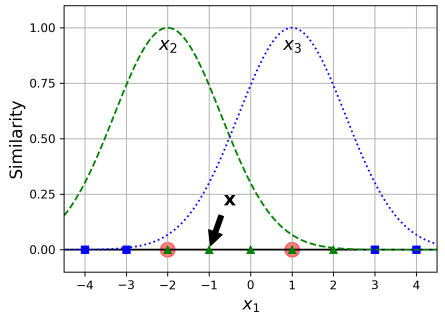

现在我们已准备好计算新特征。例如，让我们看一下实例 $x_1=–1$ ：它与第一个地标的距离为1，与第二个地标的距离为2。因此，它的新特征是 $x_2=exp(–0.3×1^2)≈0.74$ 和 $x_3=exp(–0.3×2^2)≈0.30$ 。

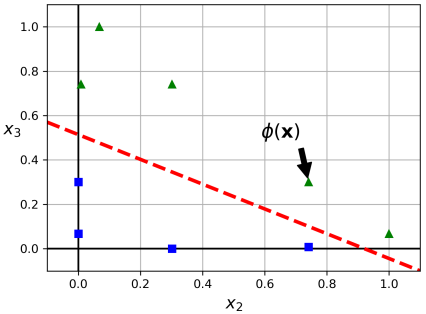

上图显示了转换后的数据集（删除了原始特征）。如你所见，它现在是线性可分的。

你可能会想知道如何选择地标。最简单的方法是在数据集中的每个实例的位置上创建一个地标。这样做可以创建许多维度，从而增加转换后的训练集是线性可分的机会。缺点是，一个有 $m$ 个实例和 $n$ 个特征的训练集被转换为一个有 $m$ 个实例和 $m$ 个特征的训练集（假设你放弃了原始特征）。如果你的训练集非常大，你最终就会得到大量等价的特性。

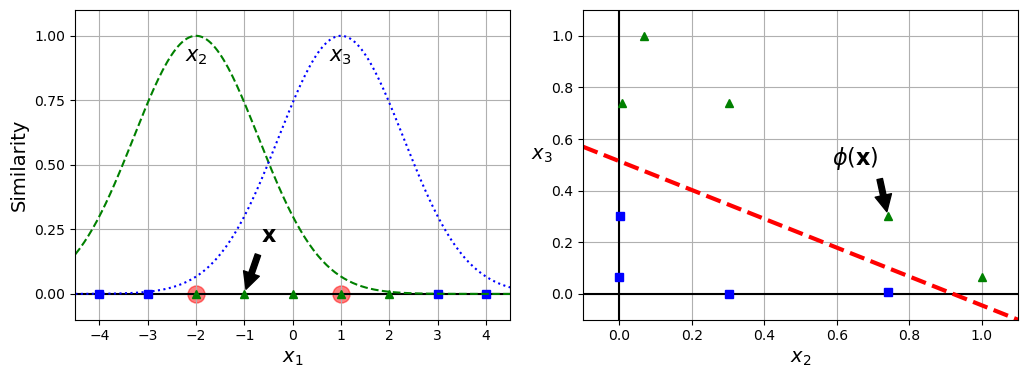

In [14]:
# extra code – this cell generates and saves Figure

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel("$x_1$")
plt.ylabel("Similarity")
plt.annotate(
    r'$\mathbf{x}$',
    xy=(X1D[3, 0], 0),
    xytext=(-0.5, 0.20),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=15)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=15)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel("$x_2$")
plt.ylabel("$x_3$  ", rotation=0)
plt.annotate(
    r'$\phi\left(\mathbf{x}\right)$',
    xy=(XK[3, 0], XK[3, 1]),
    xytext=(0.65, 0.50),
    ha="center",
    arrowprops=dict(facecolor='black', shrink=0.1),
    fontsize=16,
)
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

### 2.3 高斯RBF内核（Gaussian RBF Kernel）

就像多项式特征方法一样，相似性特征方法可用于任何机器学习算法，但计算所有附加特征（尤其是在大型训练集上）可能计算量大。内核技巧再次发挥其 SVM 的魔力，使得获得类似的结果成为可能，就好像您添加了许多相似性特征一样，但实际上并没有这样做。让我们尝试使用高斯 RBF 内核的 SVC 类：

In [17]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(),
                                   SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=5))])

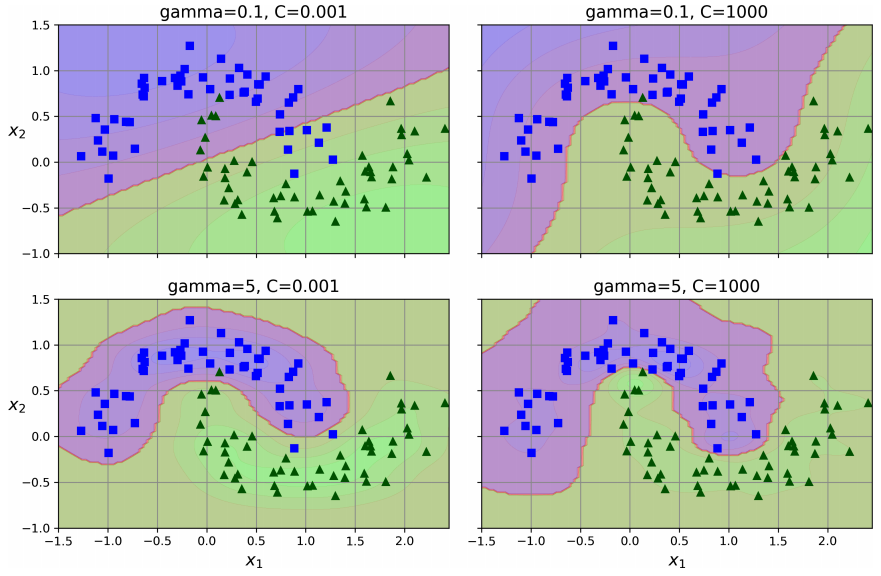

这个模型在上图的左下角所示。其他的图显示了用不同的超参数 **gamma(γ)** 和 **c** 值训练出来的模型。增加 **gamma** 会使钟形曲线变窄（见上图中的左侧图）。因此，每个实例的影响范围都更小：决策边界最终更加不规则，在单个实例周围摆动。相反，一个较小的 **gamma** 会使钟形曲线更宽：实例有更大的影响范围，而决策边界最终会更平滑。因此，**γ** 就像一个正则化超参数：如果你的模型是过拟合的，你应该减少 **γ** ；如果它是欠拟合的，你应该增加 **γ**（类似于 **C** 超参数）。

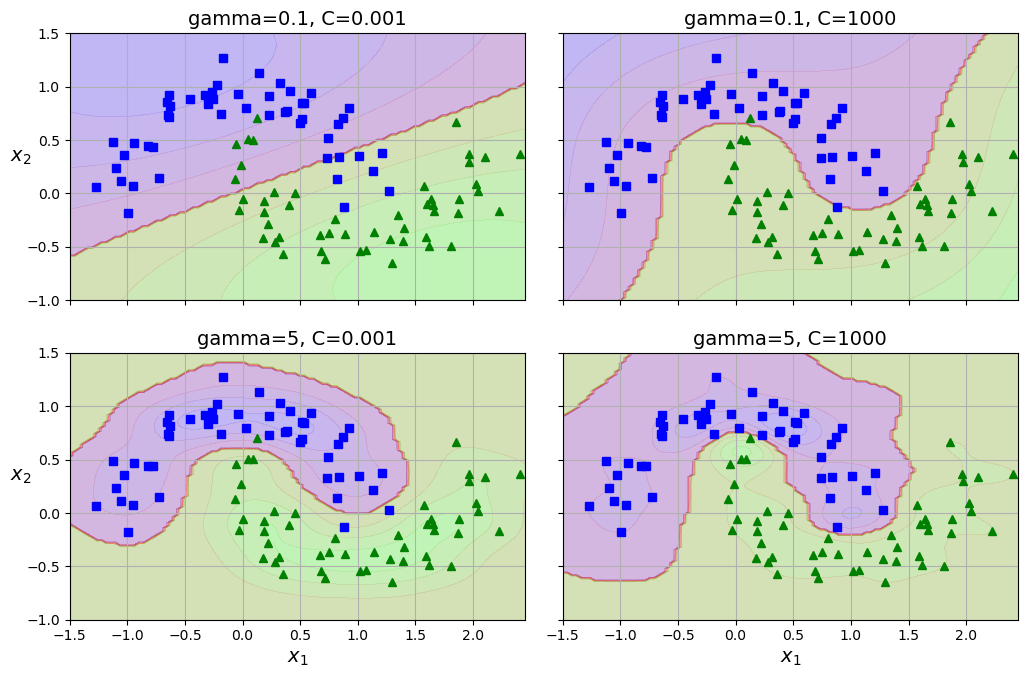

In [18]:
# extra code – this cell generates and saves Figure

from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", gamma=gamma, C=C)
    )
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(f"gamma={gamma}, C={C}")
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

其他的内核也存在，但使用得更少。有些内核是专门用于特定的数据结构的。**String kernels** 有时用于对文本文档或 DNA 序列进行分类（例如，使用字符串子序列内核或基于列文斯坦距离的内核）。

**注意**：有这么多的内核可供选择，你如何决定使用哪个呢？作为一个经验法则，您应该始终先尝试线性内核。**LinearSVC** 类比 **SVC(kernel="linear")** 要快得多，特别是当训练集非常大时。如果它不是太大，你也应该尝试内核化的支持向量机，从高斯 RBF 内核开始；它通常工作得很好。然后，如果您有空闲时间和计算能力，您可以使用超参数搜索来试验其他一些内核。如果有专门用于训练集的数据结构的内核，也一定要试一试。

### 2.4 SVM类和计算复杂度（SVM Classes and Computational Complexity）

**LinearSVC** 类基于 **liblinear** 库，实现了一种线性支持向量机的优化算法。它不支持内核技巧，但它几乎与训练实例的数量和特征的数量呈线性关系。其训练时间复杂度约为 $O(m\times n)$ 。如果您需要非常高的精度，则该算法需要更长的时间。这是由容忍超参数 $\epsilon$ （在Scikit-Learn中称为 **tol** ）控制的。在大多数分类任务中，默认的容忍超参数可以直接使用。

**SVC** 类基于 **libsvm** 库，该库实现了一个支持内核技巧的算法。训练时间的复杂度通常在 $O(m^2\times n)$ 和 $O(m^3\times n)$ 之间。不幸的是，这意味着当训练实例的数量变大（例如，成千上万的实例）时，它会变得非常慢，所以这个算法最适合中小型非线性训练集。它可以很好地扩展特征的数量，特别是使用稀疏特征（即，当每个实例很少有非零特征时）。在这种情况下，该算法大致符合每个实例的非零特征的平均数量。

**SGDClassifier** 类也默认执行大边际分类，其超参数——特别是正则化超参数（**alpha** 和 **penalty**）和 **learning_rate** ——可以进行调整，以产生与线性支持向量机相似的结果。对于训练，它使用随机梯度下降，它允许增量学习并使用很少的内存，所以您可以使用它来在不适合 RAM 的大数据集上训练模型（即用于核外学习）。此外，它的扩展度很好，因为它的计算复杂度是 $O(m\times n)$ 。

**下表比较了Scikit-Learn 的 SVM 分类器类**：

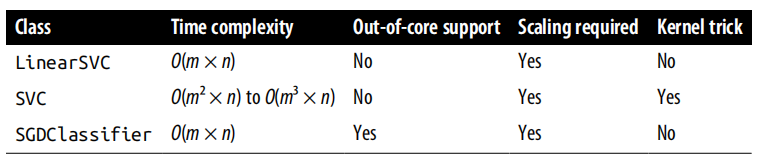

现在让我们看看 SVM 算法如何也可以用于线性和非线性回归的。

## 3. SVM 回归（SVM Regression）

要使用 SVM 进行回归而不是分类，诀窍是调整目标：SVM 回归不是试图在两个类之间拟合最大可能的街道同时限制边距违规，而是尝试在街道上拟合尽可能多的实例同时限制边距违规行为（即街道外的实例）。街道的宽度由超参数 $\epsilon$ 控制。

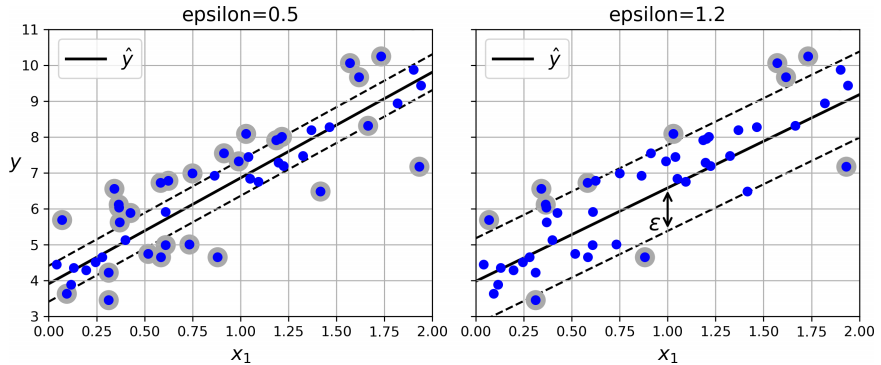

如图显示了在某些线性数据上训练的两个线性 SVM 回归模型，一个具有较小的间隔 ($\epsilon=0.5$)，另一个具有较大的间隔 ($\epsilon=1.2$)。

减少 $\epsilon$ 增加了支持向量的数量，这使模型正则化。此外，如果您在边距内添加更多的训练实例，它将不会影响模型的预测；因此，该模型被称为 $\epsilon$ 不敏感的。

可以使用 Scikit-Learn 的 **LinearSVR** 类来执行线性 SVM 回归。下面的代码生成了上图中左侧所示的模型：

In [19]:
from sklearn.svm import LinearSVR

# extra code – these 3 lines generate a simple linear dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = 4 + 3 * X[:, 0] + np.random.randn(50)

svm_reg = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, random_state=42))
svm_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(epsilon=0.5, random_state=42))])

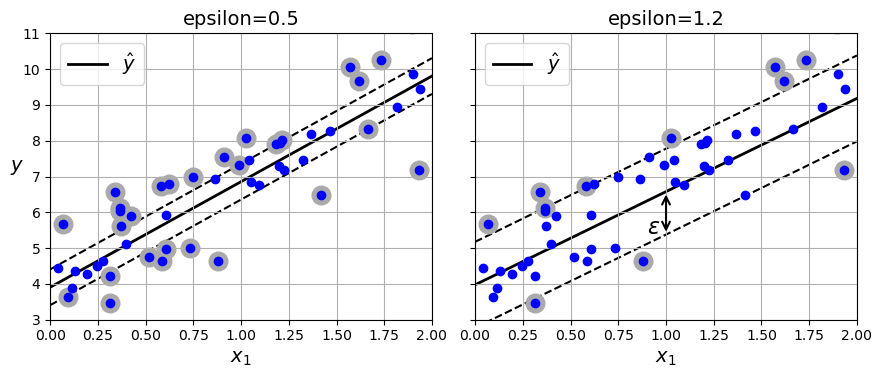

In [22]:
# extra code – this cell generates and saves Figure

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    epsilon = svm_reg[-1].epsilon
    off_margin = np.abs(y - y_pred) >= epsilon
    return np.argwhere(off_margin)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.scatter(X[svm_reg._support], y[svm_reg._support], s=180,
                facecolors='#AAA', zorder=-1)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)

svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, random_state=42))
svm_reg2.fit(X, y)

svm_reg._support = find_support_vectors(svm_reg, X, y)
svm_reg2._support = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg2.predict([[eps_x1]])

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg2[-1].epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.90, 5.4, r"$\epsilon$", fontsize=16)
plt.grid()
save_fig("svm_regression_plot")
plt.show()

要处理非线性回归任务，您可以使用内核化的SVM模型。

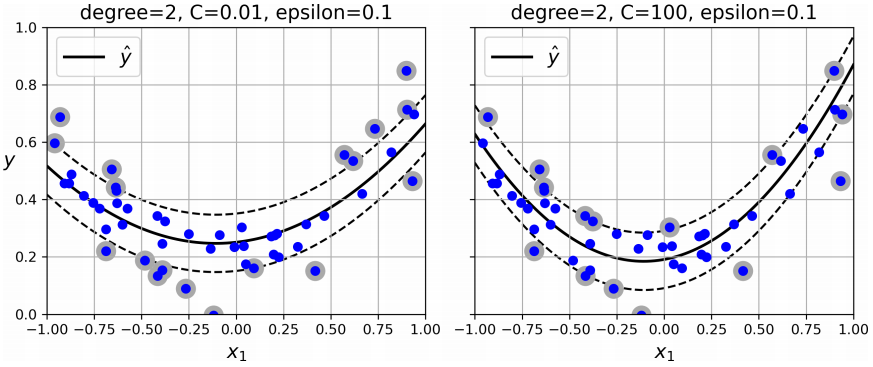

上图显示了在一个随机二次训练集上的 SVM 回归，使用了一个二次多项式核。在左边的图中有一些正则化（即，一个很小的 C 值），而在右边的图中有一些更小的正则化（即，一个很大的 C 值）。

下面的代码使用 Scikit-Learn 的 SVR 类（它支持内核技巧）来生成上图左边所示的模型：

In [23]:
from sklearn.svm import SVR

# extra code – these 3 lines generate a simple quadratic dataset
np.random.seed(42)
X = 2 * np.random.rand(50, 1) - 1
y = 0.2 + 0.1 * X[:, 0] + 0.5 * X[:, 0] ** 2 + np.random.randn(50) / 10

svm_poly_reg = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=0.01, degree=2, kernel='poly'))])

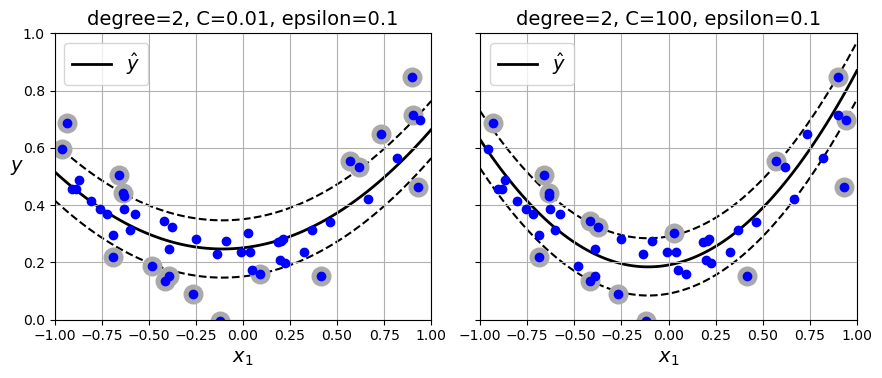

In [24]:
# extra code – this cell generates and saves Figure 5–11

svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg2.fit(X, y)

svm_poly_reg._support = find_support_vectors(svm_poly_reg, X, y)
svm_poly_reg2._support = find_support_vectors(svm_poly_reg2, X, y)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg[-1].degree}, "
          f"C={svm_poly_reg[-1].C}, "
          f"epsilon={svm_poly_reg[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

SVR 类是 SVC 类的回归等价，LinearSVR 类是 LinearSVC 类的回归等价。 LinearSVR 类随训练集的大小线性扩展（就像 LinearSVC 类），而当训练集变得非常大时，SVR 类变得太慢（就像 SVC 类）。

本章的其余部分将解释支持向量机如何进行预测，以及它们的训练算法如何工作，从线性SVM分类器开始。如果你刚刚开始机器学习，你可以安全地跳过这个，直接进入本章结尾的练习，当你想更深入地了解支持向量机时，请再回来。

## 4. 线性 SVM 分类器的底层（Under the Hood of Linear SVM Classifiers）

一个线性 SVM 分类器通过首先计算决策函数 $\pmb{\theta}^T\pmb{x}=\theta_0x_0+\cdots+\theta_nx_n$ 来预测一个新实例 $\pmb{x}$ 的类别，其中 $x_0$ 是偏差特征（总是等于1）。如果结果是正的，则预测的类 $\hat{y}$ 是正类(1)；否则它为负类(0)。这完全像 **LogisticRegression** （在第4章中讨论）。

**注意**：到目前为止，我已经使用了将所有模型参数放在一个向量 $\pmb{\theta}$ 中的约定，包括偏差项 $\theta_0$ 和输入特征权值 $\theta_1$ 到 $\theta_n$ 。这需要向所有实例添加一个偏置输入 $x_0=1$ 。另一个非常常见的约定是分离偏差项 $b$（等价于 $\theta_0$）和特征权值向量 $\pmb{w}$（包含 $\theta_1$ 到 $\theta_n$）。在这种情况下，不需要向输入特征向量中添加偏置特征，线性 SVM 的决策函数等价于 $\pmb{w}^T\pmb{x}+b=w_1x_1+\cdots+w_nx_n+b$ 。我将在这本书的其余部分中使用这个惯例。

因此，用线性 SVM 分类器进行预测是相当简单的。那训练怎么样？这需要找到权重向量 $\pmb{w}$ 和偏差项 $b$ ，使街道或边界尽可能宽，同时限制违反边界的数量。让我们从街道的宽度开始：为了让它更大，我们需要让 $\pmb{w}$ 更小。

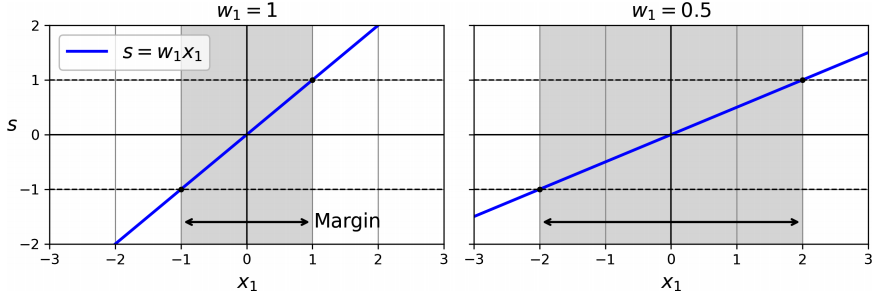

这一图可能更容易在2D中可视化，如上图所示。让我们将街道的边界定义为决策函数等于 -1 或 +1 的点。在左图中，权重 $w_1$ 为 1，因此 $w_1x_1=-1或+1$ 处的点为 $x_1=-1和+1$ ：因此边距的大小为2。在右图中，权重为 0.5，因此 $w_1x_1=-1或+1$ 处的点是 $x_1=-2和+2$ ：边距的大小为4。因此，我们需要使 $\pmb{w}$ 尽可能小。请注意，偏置项 $b$ 对边距的大小没有影响：调整它只会移动边距，而不会影响其大小。

我们还希望避免边际违规，所以我们需要决策函数对于所有正训练实例的决策函数大于 1 ，而对于负训练实例则小于 -1 。如果我们为负实例定义 $t^{(i)}=-1$（当 $y^{(i)}=0$ 时），为正实例定义 $t^{(i)}=1$（当 $y^{(i)}=1$ 时），那么我们可以将这个约束写成对于所有实例 $t^{(i)}(\pmb{W}^T\pmb{x}^{(i)}+b)\ge 1$。

因此，我们可以将硬边际线性 SVM 分类器目标表示为如下公式中的约束优化问题。

**硬边际线性 SVM 分类器目标函数**：

$$ \min_{\pmb{w},b}\ \frac12\pmb{w}^T\pmb{w} \\
subject \ to \ t^{(i)}(\pmb{w}^T\pmb{x}^{(i)}+b)\ge 1\ for \ i=1,2,\cdots,m
$$

**注意**：我们是最小化 $\frac12\pmb{w}^T\pmb{w}$ ，它等价于 $\frac12||\pmb{w}||^2$ ，而不是最小化 $||\pmb{w}||$（$\pmb{w}$ 的范数）。事实上，$\frac12||\pmb{w}||^2$ 有一个很好的、简单的导数（是 $\pmb{w}$），而 $||\pmb{w}||$ 在 $\pmb{w}=0$ 时是不可微的。优化算法通常在可微函数上工作得更好。

为了获得软边际目标函数，我们需要为每个实例引入一个松弛变量 $\zeta^{(i)}\ge0$ ：$\zeta^{(i)}$ 测量第 $i$ 个实例允许违反边际的程度。我们现在有两个相互冲突的目标：使松弛变量尽可能小以减少边际违规，使 $\frac12\pmb{w}^T\pmb{w}$ 尽可能小以增加边际。这就是 $C$ 超参数的作用所在：它允许我们定义这两个目标之间的权衡。

**软边际线性 SVM 分类器目标函数**：

$$ \min_{\pmb{w},b,\zeta}\ \frac12\pmb{w}^T \pmb{w}+C\sum_{i=1}^m\zeta^{(i)}\\
subject\ to\ t^{(i)}(\pmb{w}^T\pmb{x}^{(i)}+b)\ge1-\zeta^{(i)}\ and\ \zeta^{(i)}\ge0\ for\ i=1,2,\cdots,m 
$$

硬边际问题和软边际问题都是具有线性约束的凸二次优化问题。这些问题被称为 **二次规划（quadratic programming，QP）问题** 。许多现成的求解器可用来解决通过使用各种技术的 QP 问题，这超出了本书的范围。

使用 QP 求解器是训练 SVM 的一种方法。另一种方法是使用梯度下降来最小化 **铰链损失（hinge loss）** 或 **平方铰链损失（squared hinge loss）** 。

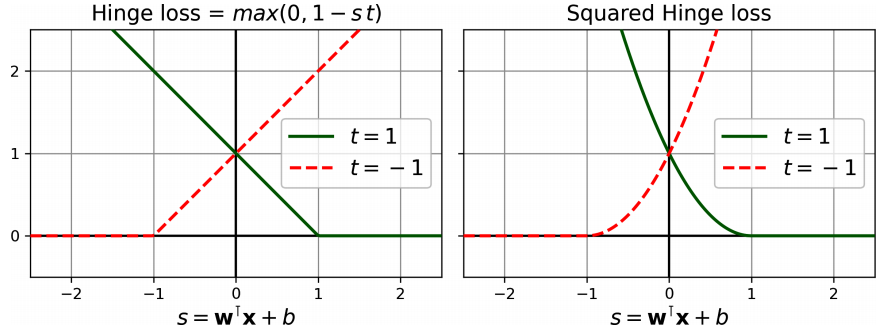

给定正类的一个实例 $\pmb{x}$（即 $t=1$），如果决策函数的输出 $s$（$s=\pmb{w}^T\pmb{x}+b$）大于或等于1，则损失为0。当实例出现在街道外并且在正类的一边时，就会发生这种情况。给定负类的一个实例（即 $t=-1$），如果是 $s\le -1$，则损失为0。当实例在街道外并且出现在负类一边时，就会发生这种情况。一个实例越远离正确的边缘一侧越远，损失就越高：铰链损失呈线性增长，铰链损失的平方呈二次增长。这使得平方铰链损失对异常值更加敏感。然而，如果数据集是干净的，它就倾向于收敛得更快。默认情况下，**LinearSVC** 使用平方铰链损失，而 **SGDClassifier** 使用铰链损失。这两个类都允许您通过将 **loss** 超参数设置为“**hinge**”或“**squared_hinge**”来选择损失。**SVC** 类的优化算法找到了一个类似的最小化铰链损失的解。

接下来，我们将研究另一种训练线性SVM分类器的方法：解决对偶问题。

## 5. 对偶问题（The Dual Problem）

给定一个约束优化问题，即 **原始问题（primal problem）**，它可以表达一个不同的但密切相关的问题，称为其 **对偶问题（dual problem）**。对偶问题的解通常给出了原问题解的下界，但在某些条件下，它可以得到与原问题相同的解。幸运的是，SVM问题恰好满足这些条件，所以你可以选择解决原始问题或对偶问题；两者都有相同的解决方案。

**线性 SVM 目标函数的对偶形式**：

$$ \min_{\pmb{\alpha}}\ \frac12\sum_{i=1}^{m}\sum_{j=1}^m\alpha^{(i)}\alpha^{(j)}t^{(i)}t^{(j)}\pmb{x}^{(i)T}\pmb{x}^{(j)}-\sum_{i=1}^m\alpha^{(i)} \\
subject\ to\ \alpha^{(i)}\ge0\ for\ all\ i=1,2,\cdots,m\ and\ \sum_{i=1}^m\alpha^{(i)}t^{(i)}=0
$$

一旦你找到了使这个方程最小化的向量 $\hat{\pmb{\alpha}}$（使用QP求解器），就使用如下方程来计算最小化原始问题的 $\hat{\pmb{w}}$ 和 $\hat{b}$ 。在这个方程中，$n_s$ 表示支持向量的数量。

**从对偶解到原解**:

$$ \hat{\pmb{w}}=\sum_{i=1}^m\hat{\alpha}^{(i)}t^{(i)}\pmb{x}^{(i)}\\
\hat{b} = \frac{1}{n_s}\sum_{i=1\ and\ \hat{\alpha}^{(i)}>0 }^m(t^{(i)}-\hat{\pmb{w}}^T\pmb{x}^{(i)})
$$

**当训练实例数小于特征数时，对偶问题比原始问题解决得更快**。更重要的是，对偶问题使内核技巧成为可能，而原始问题则不能。那么，这个内核技巧到底是什么呢？

### 5.1 内核化SVM（Kernelized SVMs）

假设你想对一个二次训练集（如月亮训练集）应用一个二次多项式变换，然后在变换后的训练集上训练一个线性 SVM 分类器。如下公式显示了您想要应用的二次多项式映射函数 $\phi$ 。

**二次多项式映射函数**：

$$ \phi(\pmb{x})=\phi
\left(\left(
\begin{matrix}
x_1 \\
x_2
\end{matrix}
\right)\right)=
\left(
\begin{matrix}
x_1^2\\
\sqrt{2}x_1x_2\\
x_2^2
\end{matrix}
\right)
$$

注意，转换后的向量是三维的，而不是二维的。现在让我们来看看一对二维向量，$\pmb{a}$ 和 $\pmb{b}$ ，如果应用这个二次多项式映射，然后计算变换向量的点积，会发生什么。

**一个二阶多项式映射的核技巧**：

$$ \phi(\pmb{a})^T\phi(\pmb{b})= 
\left(
\begin{matrix}
a_1^2\\
\sqrt{2}a_1a_2\\
a_2^2
\end{matrix}
\right)
\left(
\begin{matrix}
b_1^2\\
\sqrt{2}b_1b_2\\
b_2^2
\end{matrix}
\right)=
a_1^2b_1^2+2a_1b_1a_2b_2+a_2^2b_2^2=(a_1b_1+a_2b_2)^2=
\left(\left(
\begin{matrix}
a_1 \\
a_2
\end{matrix}
\right)^T
\left(
\begin{matrix}
b_1 \\
b_2
\end{matrix}
\right)\right)^2=(\pmb{a}^T\pmb{b})^2
$$

那怎么样？变换后的向量的点积等于原始向量的点积的平方：$\phi(\pmb{a})^T\phi(\pmb{b})=(\pmb{a}^T\pmb{b})^2$ 。

这里是关键的见解：如果您将转换 $\phi$ 应用于所有的训练实例，那么对偶问题将包含点积 $\phi(\pmb{x}^{(i)})^T\phi(\pmb{x}^{(j)})$ 。但是如果 $\phi$ 是方程中定义的二次多项式变换，那么可以用 $(\pmb{x}^{(i)T}\pmb{x}^{(j)})^2$ 来替换变换向量的点积。所以根本不需要转换训练实例；只需替换方程中的平方。结果将严格相同，就好像经历了麻烦的转换训练集，然后拟合一个线性SVM算法，但这个技巧使整个过程的计算效率更加高。

函数 $K(\pmb{a},\pmb{b})=(\pmb{a}^T\pmb{b})^2$ 是一个二次多项式核。在机器学习中，核是一个能够计算点积 $\phi(\pmb{a})^T\phi(\pmb{b})$ 的函数，仅基于原始向量 $\pmb{a}$ 和 $\pmb{b}$ ，而不需要计算（甚至知道）变换 $\phi$ 。

**一些常见的核**：
- Linear：$K(\pmb{a},\pmb{b})=\pmb{a}^T\pmb{b}$
- Polynomial：$K(\pmb{a},\pmb{b})=(\gamma\pmb{a}^T\pmb{b}+r)^d$
- Gaussian RBF：$K(\pmb{a},\pmb{b})=exp(-\gamma||\pmb{a}-\pmb{b}||^2)$
- Sigmoid：$K(\pmb{a},\pmb{b})=tanh(\gamma\pmb{a}^T\pmb{b}+r)$

**梅氏定理（Mercer’s Theorem）**：根据 Mercer 定理，如果一个函数 $K(\pmb{a},\pmb{b})$ 服从一些称为 Mercer 条件的数学条件（例如，$K$ 在其参数中必须是连续的和对称的，因此 $K(a,b)=K(b,a)$，等等），然后存在一个函数 $\phi$ ，它将 $\pmb{a}$ 和 $\pmb{b}$ 映射到另一个空间（可能具有更高的维度），使得 $K(a,b)=\phi(\pmb{a})^T\phi(\pmb{b})$ 。您可以使用 $K$ 作为内核，因为你知道 $\phi$ 存在，即使您不知道 $\phi$ 是什么。在高斯RBF核的情况下，它可以用 $\phi$ 将每个训练实例映射到一个无限维的空间，所以这是一件好事，你不需要实际执行映射！请注意，一些经常使用的内核（如 sigmoid 内核）不服从 Mercer 的所有条件，但它们在实践中通常工作得很好。

还有一个未解决的问题我们必须解决。公式显示了在线性 SVM 分类器的情况下如何从对偶解到原始解。 但是如果你应用内核技巧，你最终会得到包含 $\phi(x^{(i)})$ 的方程。 事实上，$\hat{\pmb{w}}$ 必须具有与 $\phi(x^{(i)})$ 相同的维数，它可能很大甚至是无限的，因此您无法计算它。 但是你怎么能在不知道 $\hat{\pmb{w}}$ 的情况下做出预测呢？ 好吧，好消息是您可以将 $\pmb{w]$ 代入新实例 $\pmb{x}^{(n)}$ 的决策函数，您将得到一个仅包含输入向量之间点积的方程。 这使得使用内核技巧成为可能。

**使用内核化的 SVM 进行预测**：

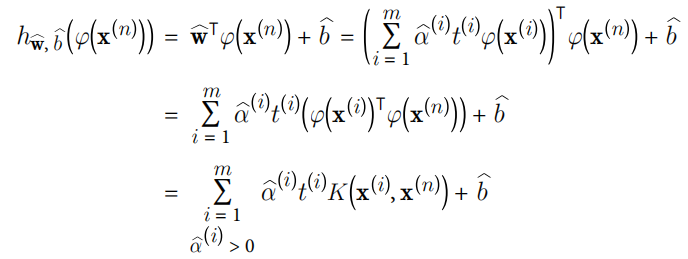

请注意，由于 $\alpha^{(i)}\ne0$ 仅用于支持向量，因此进行预测涉及到新输入向量 $\pmb{x}^{(n)}$ 的点积只与支持向量求积，而不是所有的训练实例。当然，您需要使用相同的技巧来计算偏差项 $\hat{b}$ 。

**使用核技巧来计算偏差项**：

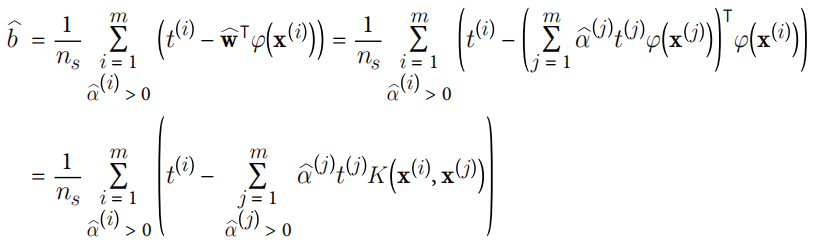

如果你开始头疼，那是完全正常的：这是内核技巧的一个不幸的副作用。

**注意**：还可以实现能够增量学习的在线内核化支持向量机，如论文“增量和解密支持向量机器学习”和“在线和主动学习的快速内核分类器”所述。这些内核化的支持向量机在 Matlab 和 C++ 中实现。但是对于大规模的非线性问题，您可能需要考虑使用随机森林（见第7章）或神经网络（见第二部分）。